In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')


In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 28*28), nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [3]:
class GAN(pl.LightningModule):
    def __init__(self, z_dim=100):
        super().__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim

        # фиксированный шум — 10 картинок
        self.test_noise = torch.randn(10, z_dim)

        self.images_per_epoch = []

        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def generator_loss(self, batch_size):
        z = torch.randn(batch_size, self.z_dim, device=self.device)
        fake = self(z)
        preds = self.discriminator(fake)
        return nn.BCELoss()(preds, torch.ones(batch_size, 1, device=self.device))

    def discriminator_loss(self, real):
        batch_size = real.size(0)
        real_preds = self.discriminator(real)
        real_loss = nn.BCELoss()(real_preds, torch.ones(batch_size, 1, device=self.device))

        z = torch.randn(batch_size, self.z_dim, device=self.device)
        fake = self(z).detach()
        fake_preds = self.discriminator(fake)
        fake_loss = nn.BCELoss()(fake_preds, torch.zeros(batch_size, 1, device=self.device))

        return real_loss + fake_loss

    def training_step(self, batch, batch_idx):
        real, _ = batch
        g_opt, d_opt = self.optimizers()

        # Generator
        g_loss = self.generator_loss(real.size(0))
        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()

        # Discriminator
        d_loss = self.discriminator_loss(real)
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()

        self.log("g_loss", g_loss, prog_bar=True)
        self.log("d_loss", d_loss, prog_bar=True)

    def configure_optimizers(self):
        g_opt = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
        d_opt = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        return [g_opt, d_opt], []

    def on_train_epoch_end(self):
        z = self.test_noise.to(self.device)
        imgs = self(z)
        self.images_per_epoch.append(imgs.detach().cpu())


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST("", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=256, shuffle=True, num_workers=8)


In [5]:
model = GAN()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\azadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name          | Type          | Params | Mode  | FLOPs
-------------------------------------

Epoch 99: 100%|██████████| 235/235 [00:17<00:00, 13.76it/s, v_num=19, g_loss=2.820, d_loss=0.289] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:17<00:00, 13.70it/s, v_num=19, g_loss=2.820, d_loss=0.289]


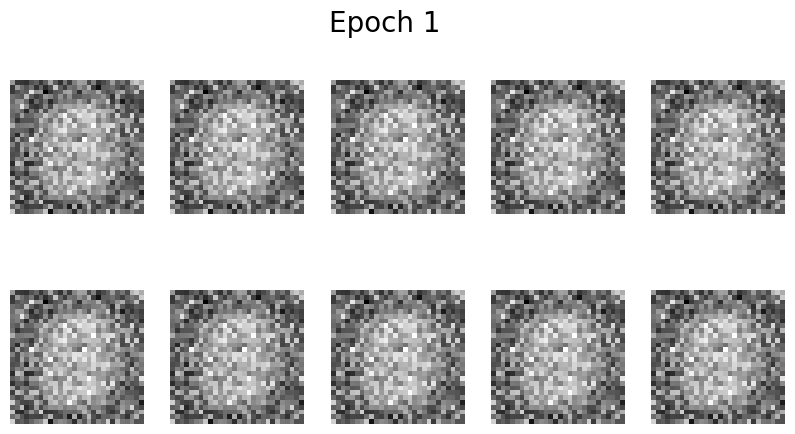

In [6]:
imgs = [epoch.numpy() for epoch in model.images_per_epoch]

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

def animate(epoch):
    fig.suptitle(f"Epoch {epoch+1}", fontsize=20)
    for i in range(10):
        ax = axs[i // 5][i % 5]
        ax.imshow(imgs[epoch][i, 0], cmap="gray")
        ax.axis("off")

ani = FuncAnimation(fig, animate, frames=len(imgs), interval=500)

ani
